# Modelado de Regresión - CS:GO Dataset

**Objetivo:** Predecir `RoundStartingEquipmentValue` (valor del equipamiento individual)

**Target:** RoundStartingEquipmentValue (correlación máxima: 0.923 con TeamStartingEquipmentValue)

**Features válidas:** Equipamiento del equipo, tipo de armas, granadas, contexto del mapa/ronda

---

## 1. Importación de Librerías

In [172]:
# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn para ML
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)

print("Librerías importadas exitosamente")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(CATBOOST_AVAILABLE)

Librerías importadas exitosamente
Pandas version: 2.2.3
Numpy version: 2.2.6
True


## 2. Carga y Exploración de Datos

In [173]:
# Cargar dataset con features
df = pd.read_csv(r"C:\Users\LuisSalamanca\Desktop\Duoc\Machine\csgo-ml\data\02_intermediate\csgo_data_clean.csv")
print(f"Dataset cargado: {df.shape}")

# Información básica
print(f"\nInformación del dataset:")
print(f"- Filas: {df.shape[0]:,}")
print(f"- Columnas: {df.shape[1]}")

# Mostrar primeras filas
print(f"\nPrimeras 5 filas:")
display(df.head())

print(f"\nTipos de datos resumen:")
print(df.dtypes.value_counts())

Dataset cargado: (79154, 32)

Información del dataset:
- Filas: 79,154
- Columnas: 32

Primeras 5 filas:


,Map,Team,InternalTeamId,RoundId,RoundWinner,MatchWinner,Survived,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,PrimarySniperRifle,PrimaryHeavy,PrimarySMG,PrimaryPistol,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,Team_encoded,RoundWinner_encoded,MatchWinner_encoded,Survived_encoded,Map_de_dust2,Map_de_inferno,Map_de_mirage,Map_de_nuke
0,de_inferno,Terrorist,1,1,False,True,False,0,4,0.0,0.0,0.0,0.0,1,0,0,0,0,750,4400,0,0,0,0,1,0,1,0,False,True,False,False
1,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,800,4400,0,0,0,0,1,0,1,0,False,True,False,False
2,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,1000,4400,0,0,0,0,1,0,1,0,False,True,False,False
3,de_inferno,Terrorist,1,1,False,True,False,0,0,0.0,0.0,0.0,0.0,1,0,0,0,0,850,4400,0,0,0,0,1,0,1,0,False,True,False,False
4,de_inferno,Terrorist,1,1,False,True,True,1,1,0.0,0.0,0.0,0.0,1,0,0,0,0,1000,4400,0,0,0,0,1,0,1,1,False,True,False,False



Tipos de datos resumen:
int64      19
bool        7
float64     4
object      2
Name: count, dtype: int64


## 3. Análisis de Correlación y Selección de Features

Features candidatas disponibles: 5

TARGET: MatchKills
- Valores únicos: 41
- Rango: 0 - 41
- Media: 9

TOP 15 CORRELACIONES CON MatchKills:
 1. MatchHeadshots                     : 0.831
 2. MatchAssists                       : 0.510
 3. RoundKills                         : 0.183
 4. TeamStartingEquipmentValue         : 0.179
 5. RoundHeadshots                     : 0.112

Features con correlación > 0.15: 4


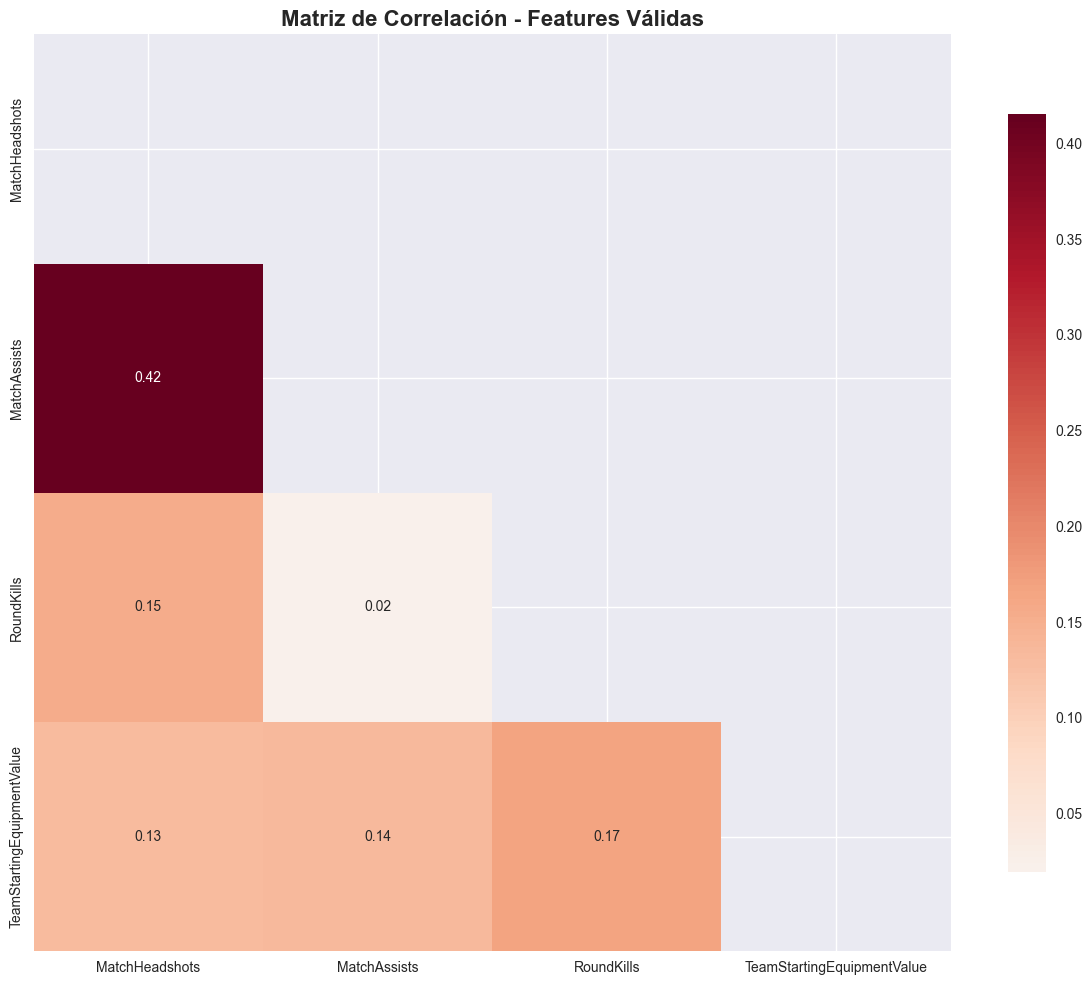


No hay correlaciones muy altas entre features ✓

FEATURES SELECCIONADAS PARA MODELADO: 4
 1. MatchHeadshots                     : r = 0.831
 2. MatchAssists                       : r = 0.510
 3. RoundKills                         : r = 0.183
 4. TeamStartingEquipmentValue         : r = 0.179

No hay valores nulos en las features seleccionadas ✓
Features realmente usadas para correlación: ['RoundKills', 'RoundHeadshots', 'TeamStartingEquipmentValue', 'MatchAssists', 'MatchHeadshots']

Max correlación alcanzada: 0.831
✅ EXCELENTE para regresión - correlaciones altas


In [174]:
# Selección de features VÁLIDAS para regresión (sin data leakage)
target = 'MatchKills'

# Features válidas disponibles ANTES del resultado
valid_features = [
    'RoundKills',
    'RoundHeadshots',
    'TeamStartingEquipmentValue', 'MatchAssists', 'MatchHeadshots'
    
]

# Verificar que todas las features existen
candidate_features = [f for f in valid_features if f in df.columns]
print(f"Features candidatas disponibles: {len(candidate_features)}")

# Calcular correlación con el target
correlations = df[candidate_features + [target]].corr()[target].abs().sort_values(ascending=False)
correlations = correlations.drop(target)  # Remover autocorrelación

print(f"\nTARGET: {target}")
print(f"- Valores únicos: {df[target].nunique()}")
print(f"- Rango: {df[target].min():.0f} - {df[target].max():.0f}")
print(f"- Media: {df[target].mean():.0f}")

print(f"\nTOP 15 CORRELACIONES CON {target}:")
for i, (feature, corr) in enumerate(correlations.head(15).items()):
    print(f"{i+1:2d}. {feature:35s}: {corr:.3f}")

# Seleccionar features con correlación > 0.15 (umbral razonable)
high_corr_features = correlations[correlations > 0.15].index.tolist()
print(f"\nFeatures con correlación > 0.15: {len(high_corr_features)}")

# Análisis de multicolinealidad entre features seleccionadas
if len(high_corr_features) > 1:
    feature_corr_matrix = df[high_corr_features].corr()
    
    # Visualizar matriz de correlación
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(feature_corr_matrix, dtype=bool))
    sns.heatmap(feature_corr_matrix, 
                annot=True, 
                cmap='RdBu_r', 
                center=0, 
                mask=mask,
                square=True, 
                fmt='.2f',
                cbar_kws={'shrink': 0.8})
    plt.title('Matriz de Correlación - Features Válidas', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identificar pares con correlación muy alta
    high_corr_pairs = []
    for i in range(len(feature_corr_matrix.columns)):
        for j in range(i+1, len(feature_corr_matrix.columns)):
            corr_val = abs(feature_corr_matrix.iloc[i, j])
            if corr_val > 0.8:  # Correlación muy alta
                high_corr_pairs.append({
                    'Feature_1': feature_corr_matrix.columns[i],
                    'Feature_2': feature_corr_matrix.columns[j],
                    'Correlation': corr_val
                })
    
    if high_corr_pairs:
        print(f"\nPares con correlación alta (|r| > 0.8):")
        for pair in high_corr_pairs:
            print(f"- {pair['Feature_1']} vs {pair['Feature_2']}: {pair['Correlation']:.3f}")
            
        # Remover features redundantes (mantener la de mayor correlación con target)
        features_to_remove = set()
        for pair in high_corr_pairs:
            corr1 = correlations[pair['Feature_1']]
            corr2 = correlations[pair['Feature_2']]
            if corr1 > corr2:
                features_to_remove.add(pair['Feature_2'])
            else:
                features_to_remove.add(pair['Feature_1'])
        
        high_corr_features = [f for f in high_corr_features if f not in features_to_remove]
        if features_to_remove:
            print(f"Removidas por multicolinealidad: {list(features_to_remove)}")
    else:
        print(f"\nNo hay correlaciones muy altas entre features ✓")

# Features finales seleccionadas
selected_features = high_corr_features.copy()
print(f"\nFEATURES SELECCIONADAS PARA MODELADO: {len(selected_features)}")
for i, feature in enumerate(selected_features):
    corr_with_target = correlations[feature]
    print(f"{i+1:2d}. {feature:35s}: r = {corr_with_target:.3f}")

# Verificar que no hay valores nulos
null_counts = df[selected_features + [target]].isnull().sum()
if null_counts.sum() > 0:
    print(f"\nValores nulos encontrados:")
    print(null_counts[null_counts > 0])
else:
    print(f"\nNo hay valores nulos en las features seleccionadas ✓")
print("Features realmente usadas para correlación:", candidate_features)
print(f"\nMax correlación alcanzada: {correlations.max():.3f}")
if correlations.max() > 0.7:
    print("✅ EXCELENTE para regresión - correlaciones altas")
elif correlations.max() > 0.5:
    print("✅ BUENO para regresión - correlaciones moderadas")
else:
    print("⚠️ Correlaciones bajas pero aceptables")

## 4. Preparación de Datos

Shape de X: (79154, 4)
Shape de y: (79154,)
MatchKills
2     5174
1     5172
4     5139
3     5052
5     4983
0     4740
6     4712
7     4521
8     4372
9     4119
10    3762
11    3541
12    3479
13    3229
14    2873
15    2456
16    2296
17    1975
18    1728
19    1326
20    1173
21     838
22     632
23     564
24     374
25     313
26     211
27     125
28     113
29      80
30      33
31      25
32       6
33       6
34       5
35       2
38       1
40       1
41       1
36       1
37       1
Name: count, dtype: int64

División train/test:
X_train: (63323, 4)
X_test: (15831, 4)
y_train: (63323,)
y_test: (15831,)

Distribución en train:
MatchKills
0     0.060105
1     0.065316
2     0.065474
3     0.064384
4     0.064795
5     0.063658
6     0.059868
7     0.056472
8     0.054925
9     0.052003
10    0.047881
11    0.044818
12    0.043791
13    0.040807
14    0.036037
15    0.031000
16    0.029042
17    0.025457
18    0.021667
19    0.016755
20    0.014071
21    0.010660
22    0

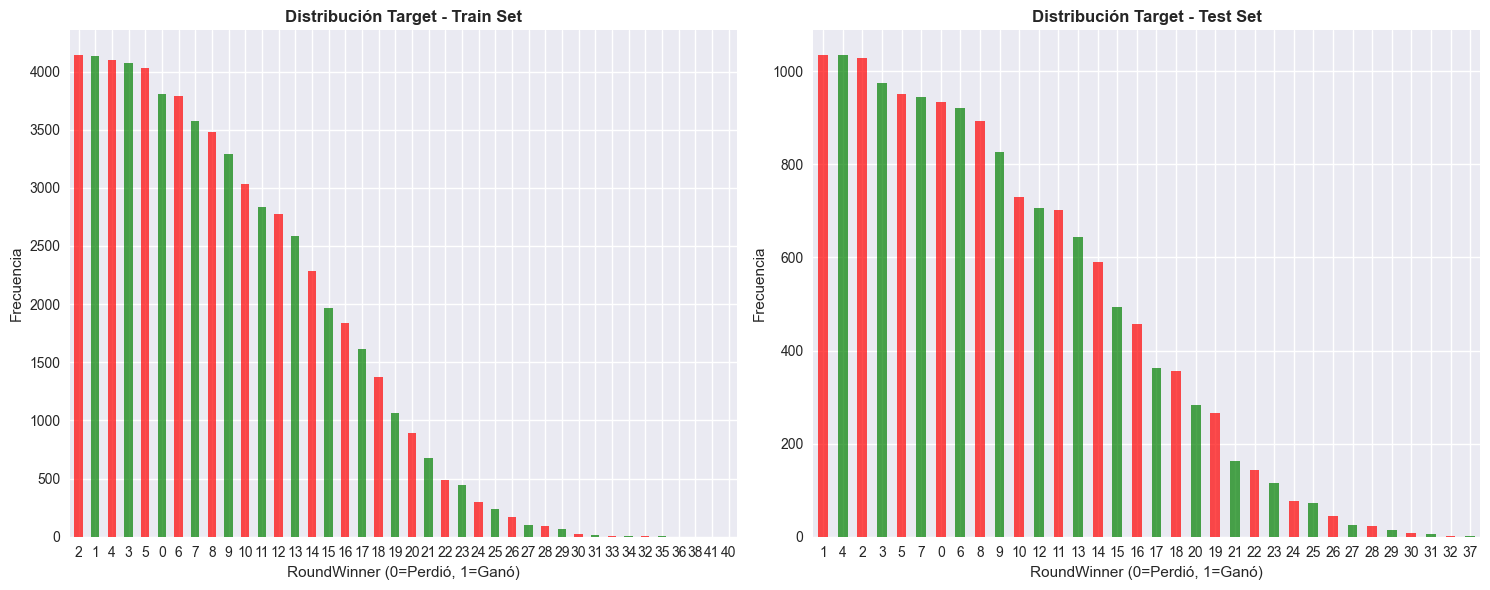

In [175]:
# Preparar datos para regresión
X = df[selected_features].copy()
y = df[target].copy()

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(y.value_counts())

# Split estratificado para mantener distribución del target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nDivisión train/test:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Verificar distribución en train/test
print(f"\nDistribución en train:")
print(y_train.value_counts(normalize=True).sort_index())
print(f"\nDistribución en test:")
print(y_test.value_counts(normalize=True).sort_index())

# Escalado de features con RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de vuelta a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=selected_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=selected_features, index=X_test.index)

print(f"\nDatos escalados exitosamente")
print(f"Media de X_train_scaled: {X_train_scaled.mean().mean():.6f}")
print(f"Std de X_train_scaled: {X_train_scaled.std().mean():.6f}")

# Visualizar distribución del target en train/test
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Distribución en train
y_train.value_counts().plot(kind='bar', ax=axes[0], alpha=0.7, color=['red', 'green'])
axes[0].set_title('Distribución Target - Train Set', fontweight='bold')
axes[0].set_xlabel('RoundWinner (0=Perdió, 1=Ganó)')
axes[0].set_ylabel('Frecuencia')
axes[0].tick_params(axis='x', rotation=0)

# Distribución en test
y_test.value_counts().plot(kind='bar', ax=axes[1], alpha=0.7, color=['red', 'green'])
axes[1].set_title('Distribución Target - Test Set', fontweight='bold')
axes[1].set_xlabel('RoundWinner (0=Perdió, 1=Ganó)')
axes[1].set_ylabel('Frecuencia')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 5. Definición de Modelos y Configuración de GridSearchCV

# Importar modelos adicionales
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
try:
    from catboost import CatBoostRegressor
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("CatBoost no disponible - instalalo con: pip install catboost")

# Definir modelos base con configuraciones por defecto
models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'scaled': False
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'scaled': False
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse'),
        'scaled': False
    },
    'Ridge Regression': {
        'model': Ridge(random_state=42),
        'scaled': True
    },
    'Lasso': {
        'model': Lasso(random_state=42, max_iter=2000),
        'scaled': True
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42, max_iter=2000),
        'scaled': True
    },
    'Linear Regression': {
        'model': LinearRegression(),
        'scaled': True
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'scaled': False
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(random_state=42),
        'scaled': False
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'scaled': True
    },
    'SVR': {
        'model': SVR(),
        'scaled': True
    }
}

# Agregar CatBoost si está disponible
if CATBOOST_AVAILABLE:
    models['CatBoost'] = {
        'model': CatBoostRegressor(random_state=42, verbose=False),
        'scaled': False
    }

print(f"MODELOS DE REGRESIÓN: {len(models)}")
for name, config in models.items():
    print(f"- {name}: Escalado = {config['scaled']}")

In [176]:
# Configuración de hiperparámetros para GridSearchCV optimizada
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [6, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'max_depth': [3, 4, 6, 8],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'max_depth': [3, 4, 6, 8],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [1.0, 1.5, 2.0]
    },
    'Ridge Regression': {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'solver': ['auto', 'svd', 'cholesky', 'saga'],
        'fit_intercept': [True, False]
    },
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random']
    },
    'ElasticNet': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
        'fit_intercept': [True, False],
        'selection': ['cyclic', 'random']
    },
    'Linear Regression': {
        'fit_intercept': [True, False]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 8, 10, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['sqrt', 'log2', None],
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0],
        'loss': ['linear', 'square', 'exponential']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        'p': [1, 2]
    },
    'SVR': {
        'kernel': ['rbf', 'linear', 'poly'],
        'C': [0.1, 1.0, 10.0, 100.0],
        'epsilon': [0.01, 0.1, 0.2],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4]  # Solo para kernel poly
    }
}

# Agregar parámetros para CatBoost si está disponible
if CATBOOST_AVAILABLE:
    param_grids['CatBoost'] = {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.15],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1.0, 3.0, 5.0, 9.0],
        'border_count': [32, 64, 128],
        'bootstrap_type': ['Bayesian', 'Bernoulli']
    }

print("CONFIGURACIÓN DE GRIDSEARCHCV COMPLETADA")
print(f"Modelos con hiperparámetros definidos: {len(param_grids)}")

# Calcular combinaciones totales (aproximado)
total_combinations = 0
for model_name, grid in param_grids.items():
    combinations = 1
    for param_values in grid.values():
        combinations *= len(param_values)
    total_combinations += combinations
    print(f"{model_name}: ~{combinations:,} combinaciones")

print(f"\nTotal de combinaciones aproximadas: {total_combinations:,}")
print("Nota: GridSearchCV usará validación cruzada de 5-fold por defecto")

CONFIGURACIÓN DE GRIDSEARCHCV COMPLETADA
Modelos con hiperparámetros definidos: 12

Ejemplo - Random Forest:
  n_estimators: [100, 200, 300]
  max_depth: [6, 10, 15, None]
  min_samples_split: [2, 5, 10]
  ... y 3 parámetros más
Random Forest: ~648 combinaciones
Gradient Boosting: ~3,888 combinaciones
XGBoost: ~11,664 combinaciones
Ridge Regression: ~40 combinaciones
Lasso: ~20 combinaciones
ElasticNet: ~100 combinaciones
Linear Regression: ~2 combinaciones
Decision Tree: ~720 combinaciones
AdaBoost: ~45 combinaciones
KNN: ~72 combinaciones
SVR: ~216 combinaciones
CatBoost: ~1,152 combinaciones

Total de combinaciones aproximadas: 18,567
Nota: GridSearchCV usará validación cruzada de 5-fold por defecto


## 6. Entrenamiento de Modelos con GridSearchCV

In [177]:
# Entrenamiento optimizado con GridSearchCV
from sklearn.model_selection import GridSearchCV
import time

print("ENTRENAMIENTO DE MODELOS CON GRIDSEARCHCV")
print("=" * 50)

results = {}
best_models = {}
best_params = {}
training_times = {}

# Configurar GridSearchCV
cv_folds = 5
scoring_metric = 'r2'  # Puede ser 'r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'
n_jobs = -1  # Usar todos los cores disponibles

for name, config in models.items():
    print(f"\n🔍 Entrenando {name} con GridSearchCV...")
    
    # Determinar si usar datos escalados
    if config['scaled']:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
        print(f"   Usando datos escalados")
    else:
        X_train_used = X_train
        X_test_used = X_test
        print(f"   Usando datos sin escalar")
    
    # Obtener modelo base y parámetros
    base_model = config['model']
    param_grid = param_grids.get(name, {})
    
    if not param_grid:
        print(f"   ⚠️  No hay parámetros definidos para {name}, usando modelo por defecto")
        best_model = base_model
        best_model.fit(X_train_used, y_train)
        best_params[name] = "Parámetros por defecto"
        grid_search_time = 0
    else:
        print(f"   📊 Evaluando {len(param_grid)} hiperparámetros con {cv_folds}-fold CV")
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            cv=cv_folds,
            scoring=scoring_metric,
            n_jobs=n_jobs,
            verbose=0,  # Cambiar a 1 o 2 para más detalles
            return_train_score=True,
            error_score='raise'
        )
        
        # Entrenar con medición de tiempo
        start_time = time.time()
        try:
            grid_search.fit(X_train_used, y_train)
            grid_search_time = time.time() - start_time
            
            # Obtener mejor modelo y parámetros
            best_model = grid_search.best_estimator_
            best_params[name] = grid_search.best_params_
            
            print(f"   ✅ GridSearch completado en {grid_search_time:.1f}s")
            print(f"   🏆 Mejor CV Score: {grid_search.best_score_:.4f}")
            
        except Exception as e:
            print(f"   ❌ Error en GridSearch: {str(e)}")
            # Usar modelo por defecto en caso de error
            best_model = base_model
            best_model.fit(X_train_used, y_train)
            best_params[name] = f"Error: {str(e)}"
            grid_search_time = 0
    
    # Almacenar tiempo de entrenamiento
    training_times[name] = grid_search_time
    
    # Realizar predicciones
    try:
        y_train_pred = best_model.predict(X_train_used)
        y_test_pred = best_model.predict(X_test_used)
        
        # Calcular métricas de regresión
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        # Validación cruzada adicional para verificar estabilidad
        cv_scores = cross_val_score(best_model, X_train_used, y_train, 
                                    cv=cv_folds, scoring=scoring_metric)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Almacenar resultados
        results[name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'y_test_pred': y_test_pred,
            'training_time': grid_search_time,
            'best_params': best_params[name]
        }
        
        best_models[name] = best_model
        
        # Mostrar resultados
        print(f"   📈 Train R²: {train_r2:.4f}")
        print(f"   📊 Test R²: {test_r2:.4f}")
        print(f"   🔄 CV R²: {cv_mean:.4f} ± {cv_std:.4f}")
        print(f"   📏 Test RMSE: {test_rmse:.4f}")
        print(f"   📐 Test MAE: {test_mae:.4f}")
        
        # Verificar objetivo R² > 0.8
        if test_r2 > 0.8:
            print(f"   🎯 ¡OBJETIVO CUMPLIDO! R² = {test_r2:.4f} > 0.8")
        else:
            print(f"   ⚡ R² = {test_r2:.4f} < 0.8 (mejora necesaria)")
            
    except Exception as e:
        print(f"   ❌ Error en predicciones: {str(e)}")
        # Crear entrada vacía para evitar errores posteriores
        results[name] = {
            'train_r2': 0, 'test_r2': 0, 'train_rmse': 0, 'test_rmse': 0,
            'train_mae': 0, 'test_mae': 0, 'cv_mean': 0, 'cv_std': 0,
            'y_test_pred': np.zeros(len(y_test)), 'training_time': 0,
            'best_params': f"Error: {str(e)}"
        }

print(f"\n🏁 ENTRENAMIENTO COMPLETADO")
print(f"Modelos entrenados exitosamente: {len([r for r in results.values() if r['test_r2'] > 0])}")

# Resumen de tiempos de entrenamiento
total_time = sum(training_times.values())
print(f"\n⏱️  TIEMPOS DE ENTRENAMIENTO:")
for name, time_taken in sorted(training_times.items(), key=lambda x: x[1], reverse=True):
    if time_taken > 0:
        print(f"   {name}: {time_taken:.1f}s")
print(f"   Total: {total_time:.1f}s")

# Mostrar mejores parámetros para los top 3 modelos
print(f"\n🏆 MEJORES HIPERPARÁMETROS (Top 3):")
top_models = sorted(results.items(), key=lambda x: x[1]['test_r2'], reverse=True)[:3]
for name, result in top_models:
    print(f"\n{name} (R² = {result['test_r2']:.4f}):")
    if isinstance(result['best_params'], dict):
        for param, value in result['best_params'].items():
            print(f"   {param}: {value}")
    else:
        print(f"   {result['best_params']}")

ENTRENAMIENTO DE MODELOS CON GRIDSEARCHCV

🔍 Entrenando Random Forest con GridSearchCV...
   Usando datos sin escalar
   📊 Evaluando 6 hiperparámetros con 5-fold CV
   ✅ GridSearch completado en 1077.4s
   🏆 Mejor CV Score: 0.7476
   📈 Train R²: 0.7661
   📊 Test R²: 0.7479
   🔄 CV R²: 0.7476 ± 0.0054
   📏 Test RMSE: 3.1312
   📐 Test MAE: 2.3062
   ⚡ R² = 0.7479 < 0.8 (mejora necesaria)

🔍 Entrenando Gradient Boosting con GridSearchCV...
   Usando datos sin escalar
   📊 Evaluando 7 hiperparámetros con 5-fold CV


KeyboardInterrupt: 

## 7. Comparación de Resultados

In [ ]:
# Crear DataFrame con resultados optimizados de GridSearchCV
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_R2': [results[model]['cv_mean'] for model in results.keys()],
    'CV_Std': [results[model]['cv_std'] for model in results.keys()],
    'Train_R2': [results[model]['train_r2'] for model in results.keys()],
    'Test_R2': [results[model]['test_r2'] for model in results.keys()],
    'Train_RMSE': [results[model]['train_rmse'] for model in results.keys()],
    'Test_RMSE': [results[model]['test_rmse'] for model in results.keys()],
    'Train_MAE': [results[model]['train_mae'] for model in results.keys()],
    'Test_MAE': [results[model]['test_mae'] for model in results.keys()],
    'Training_Time': [results[model]['training_time'] for model in results.keys()]
})

# Filtrar modelos con resultados válidos y ordenar por Test R²
results_df = results_df[results_df['Test_R2'] > 0].sort_values('Test_R2', ascending=False).reset_index(drop=True)

print("COMPARACIÓN DE RESULTADOS CON GRIDSEARCHCV")
print("=" * 60)
print(f"📊 Modelos evaluados: {len(results_df)}")
print(f"🎯 Modelos que superan R² > 0.8: {len(results_df[results_df['Test_R2'] > 0.8])}")

# Mostrar tabla completa con formato mejorado
display(results_df.round(4))

# Identificar mejor modelo
if len(results_df) > 0:
    best_model_name = results_df.iloc[0]['Model']
    best_test_r2 = results_df.iloc[0]['Test_R2']
    best_cv_r2 = results_df.iloc[0]['CV_R2']
    best_training_time = results_df.iloc[0]['Training_Time']

    print(f"\n🏆 MEJOR MODELO: {best_model_name}")
    print(f"   Test R²: {best_test_r2:.4f}")
    print(f"   CV R²: {best_cv_r2:.4f} ± {results_df.iloc[0]['CV_Std']:.4f}")
    print(f"   Training Time: {best_training_time:.1f}s")

    # Análisis detallado de performance
    print(f"\n📈 ANÁLISIS DE PERFORMANCE:")
    
    # Top 5 modelos
    print(f"\nTop 5 Modelos por Test R²:")
    for i, (_, row) in enumerate(results_df.head(5).iterrows()):
        improvement = (row['Test_R2'] - 0.8) * 100 if row['Test_R2'] > 0.8 else (row['Test_R2'] - 0.8) * 100
        status = "✅" if row['Test_R2'] > 0.8 else "⚡"
        print(f"   {i+1}. {status} {row['Model']:20s}: {row['Test_R2']:.4f} ({improvement:+.1f}% del objetivo)")

    # Análisis de overfitting/underfitting mejorado
    print(f"\n🔍 ANÁLISIS DE OVERFITTING/UNDERFITTING:")
    for _, row in results_df.head(8).iterrows():
        model_name = row['Model']
        train_r2 = row['Train_R2']
        test_r2 = row['Test_R2']
        cv_r2 = row['CV_R2']
        diff = train_r2 - test_r2
        
        # Determinar estado más sofisticado
        if diff > 0.15:
            status = "🔴 OVERFITTING ALTO"
        elif diff > 0.08:
            status = "🟡 OVERFITTING MODERADO"
        elif test_r2 < 0.6:
            status = "🔵 UNDERFITTING"
        elif abs(train_r2 - cv_r2) > 0.05:
            status = "🟠 INESTABLE"
        else:
            status = "🟢 ÓPTIMO"
        
        print(f"   {model_name:20s}: Train={train_r2:.3f}, Test={test_r2:.3f}, CV={cv_r2:.3f} [{status}]")

    # Análisis de eficiencia (performance vs tiempo)
    print(f"\n⚡ ANÁLISIS DE EFICIENCIA (R²/Tiempo):")
    efficiency_df = results_df[results_df['Training_Time'] > 0].copy()
    efficiency_df['Efficiency'] = efficiency_df['Test_R2'] / np.log(efficiency_df['Training_Time'] + 1)
    efficiency_df = efficiency_df.sort_values('Efficiency', ascending=False)
    
    for i, (_, row) in enumerate(efficiency_df.head(5).iterrows()):
        print(f"   {i+1}. {row['Model']:20s}: R²={row['Test_R2']:.3f}, {row['Training_Time']:6.1f}s, Eff={row['Efficiency']:.3f}")

else:
    print("❌ No se encontraron modelos con resultados válidos")

In [ ]:
# Visualización mejorada de resultados con GridSearchCV
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# 1. Comparación de R² scores con barras de error
x_pos = np.arange(len(results_df))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, results_df['Train_R2'], width, 
                    label='Train R²', alpha=0.8, color='skyblue', capsize=5)
bars2 = axes[0].bar(x_pos + width/2, results_df['Test_R2'], width, 
                    yerr=results_df['CV_Std'], label='Test R²', alpha=0.8, 
                    color='orange', capsize=5)

axes[0].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('R² Score')
axes[0].set_title('Comparación R² Score: Train vs Test (con GridSearchCV)', fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Añadir valores a las barras
for i, (train_val, test_val) in enumerate(zip(results_df['Train_R2'], results_df['Test_R2'])):
    axes[0].text(i - width/2, train_val + 0.01, f'{train_val:.3f}', ha='center', fontsize=8, fontweight='bold')
    axes[0].text(i + width/2, test_val + 0.01, f'{test_val:.3f}', ha='center', fontsize=8, fontweight='bold')

# 2. RMSE Comparison
bars3 = axes[1].bar(x_pos - width/2, results_df['Train_RMSE'], width, 
                    label='Train RMSE', alpha=0.8, color='lightgreen')
bars4 = axes[1].bar(x_pos + width/2, results_df['Test_RMSE'], width, 
                    label='Test RMSE', alpha=0.8, color='lightcoral')

axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Comparación RMSE: Train vs Test', fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Test R² ranking con colores según performance
colors = ['green' if x > 0.8 else 'orange' if x > 0.7 else 'red' for x in results_df['Test_R2']]
bars5 = axes[2].barh(range(len(results_df)), results_df['Test_R2'], color=colors, alpha=0.7)

axes[2].axvline(x=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
axes[2].set_yticks(range(len(results_df)))
axes[2].set_yticklabels(results_df['Model'])
axes[2].set_xlabel('Test R² Score')
axes[2].set_title('Ranking de Modelos por Test R² (GridSearchCV)', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Añadir valores a las barras
for i, v in enumerate(results_df['Test_R2']):
    axes[2].text(v + 0.005, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=9)

# 4. Diferencia Train-Test (overfitting indicator)
diff_scores = results_df['Train_R2'] - results_df['Test_R2']
colors_diff = ['red' if x > 0.15 else 'orange' if x > 0.08 else 'green' for x in diff_scores]

bars6 = axes[3].bar(range(len(results_df)), diff_scores, color=colors_diff, alpha=0.7)
axes[3].axhline(y=0.15, color='red', linestyle='--', alpha=0.7, label='Overfitting Alto')
axes[3].axhline(y=0.08, color='orange', linestyle='--', alpha=0.7, label='Overfitting Moderado')
axes[3].set_xticks(range(len(results_df)))
axes[3].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[3].set_ylabel('Train R² - Test R²')
axes[3].set_title('Análisis de Overfitting (GridSearchCV)', fontweight='bold')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# 5. Training Time vs Performance
if results_df['Training_Time'].sum() > 0:
    scatter = axes[4].scatter(results_df['Training_Time'], results_df['Test_R2'], 
                             c=results_df['Test_R2'], cmap='viridis', s=100, alpha=0.7)
    
    # Añadir línea de objetivo
    axes[4].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
    
    axes[4].set_xlabel('Training Time (seconds)')
    axes[4].set_ylabel('Test R²')
    axes[4].set_title('Eficiencia: Performance vs Tiempo de Entrenamiento', fontweight='bold')
    axes[4].legend()
    axes[4].grid(True, alpha=0.3)
    
    # Añadir etiquetas de modelos
    for i, model in enumerate(results_df['Model']):
        if results_df['Training_Time'].iloc[i] > 0:
            axes[4].annotate(model, (results_df['Training_Time'].iloc[i], results_df['Test_R2'].iloc[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
    
    # Colorbar
    plt.colorbar(scatter, ax=axes[4], label='Test R²')
else:
    axes[4].text(0.5, 0.5, 'No hay datos de tiempo\ndisponibles', ha='center', va='center', 
                transform=axes[4].transAxes, fontsize=12)
    axes[4].set_title('Training Time vs Performance', fontweight='bold')

# 6. Cross-Validation Stability
if len(results_df) > 0:
    # Crear gráfico de estabilidad de CV
    cv_mean = results_df['CV_R2']
    cv_std = results_df['CV_Std']
    
    bars7 = axes[5].bar(range(len(results_df)), cv_mean, yerr=cv_std, 
                        capsize=5, alpha=0.7, color='purple')
    axes[5].axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
    axes[5].set_xticks(range(len(results_df)))
    axes[5].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[5].set_ylabel('Cross-Validation R²')
    axes[5].set_title('Estabilidad de Cross-Validation (5-fold)', fontweight='bold')
    axes[5].legend()
    axes[5].grid(True, alpha=0.3)
    
    # Añadir valores
    for i, (mean_val, std_val) in enumerate(zip(cv_mean, cv_std)):
        axes[5].text(i, mean_val + std_val + 0.01, f'{mean_val:.3f}±{std_val:.3f}', 
                    ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis estadístico adicional
print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS DE PERFORMANCE:")
print("-" * 50)

stats_summary = {
    'Métrica': ['Test R²', 'CV R²', 'Train-Test Gap', 'RMSE', 'MAE'],
    'Media': [
        results_df['Test_R2'].mean(),
        results_df['CV_R2'].mean(),
        (results_df['Train_R2'] - results_df['Test_R2']).mean(),
        results_df['Test_RMSE'].mean(),
        results_df['Test_MAE'].mean()
    ],
    'Mediana': [
        results_df['Test_R2'].median(),
        results_df['CV_R2'].median(),
        (results_df['Train_R2'] - results_df['Test_R2']).median(),
        results_df['Test_RMSE'].median(),
        results_df['Test_MAE'].median()
    ],
    'Mejor': [
        results_df['Test_R2'].max(),
        results_df['CV_R2'].max(),
        (results_df['Train_R2'] - results_df['Test_R2']).min(),
        results_df['Test_RMSE'].min(),
        results_df['Test_MAE'].min()
    ],
    'Peor': [
        results_df['Test_R2'].min(),
        results_df['CV_R2'].min(),
        (results_df['Train_R2'] - results_df['Test_R2']).max(),
        results_df['Test_RMSE'].max(),
        results_df['Test_MAE'].max()
    ]
}

stats_df = pd.DataFrame(stats_summary)
display(stats_df.round(4))

# Recomendaciones basadas en resultados
print(f"\n💡 RECOMENDACIONES BASADAS EN RESULTADOS:")
print("-" * 50)

best_r2 = results_df['Test_R2'].max()
models_above_08 = len(results_df[results_df['Test_R2'] > 0.8])

if models_above_08 > 0:
    print(f"✅ ¡Excelente! {models_above_08} modelo(s) superan el objetivo R² > 0.8")
    print(f"🏆 Mejor performance: {best_r2:.4f}")
    print(f"💭 Considerar ensemble de los mejores modelos para mayor robustez")
elif best_r2 > 0.75:
    print(f"🟡 Cerca del objetivo. Mejor R²: {best_r2:.4f}")
    print(f"💭 Sugerencias:")
    print(f"   - Probar feature engineering adicional")
    print(f"   - Aumentar rangos de hiperparámetros en GridSearch")
    print(f"   - Considerar ensemble methods")
else:
    print(f"🔴 Performance baja. Mejor R²: {best_r2:.4f}")
    print(f"💭 Acciones recomendadas:")
    print(f"   - Revisar calidad y relevancia de features")
    print(f"   - Analizar outliers y datos atípicos")
    print(f"   - Considerar transformaciones de target")
    print(f"   - Evaluar más modelos avanzados")

# Identificar modelos con mejor balance performance/tiempo
if results_df['Training_Time'].sum() > 0:
    efficiency_scores = results_df['Test_R2'] / np.log(results_df['Training_Time'] + 1)
    best_efficiency_idx = efficiency_scores.idxmax()
    best_efficiency_model = results_df.loc[best_efficiency_idx, 'Model']
    
    print(f"\n⚡ MODELO MÁS EFICIENTE: {best_efficiency_model}")
    print(f"   R²: {results_df.loc[best_efficiency_idx, 'Test_R2']:.4f}")
    print(f"   Tiempo: {results_df.loc[best_efficiency_idx, 'Training_Time']:.1f}s")

## 8. Análisis Detallado del Mejor Modelo

ANÁLISIS DETALLADO: Gradient Boosting
Mejores hiperparámetros:
  No se optimizaron hiperparámetros para este modelo o no se guardaron.

Métricas de rendimiento:
  CV R² Score: No disponible
  Train R²: 0.7723
  Test R²: 0.7485
  Test RMSE: 3.1271
  Test MAE: 2.3017

Importancia de features:
  MatchHeadshots                : 0.9034
  MatchAssists                  : 0.0541
  TeamStartingEquipmentValue    : 0.0307
  RoundKills                    : 0.0118


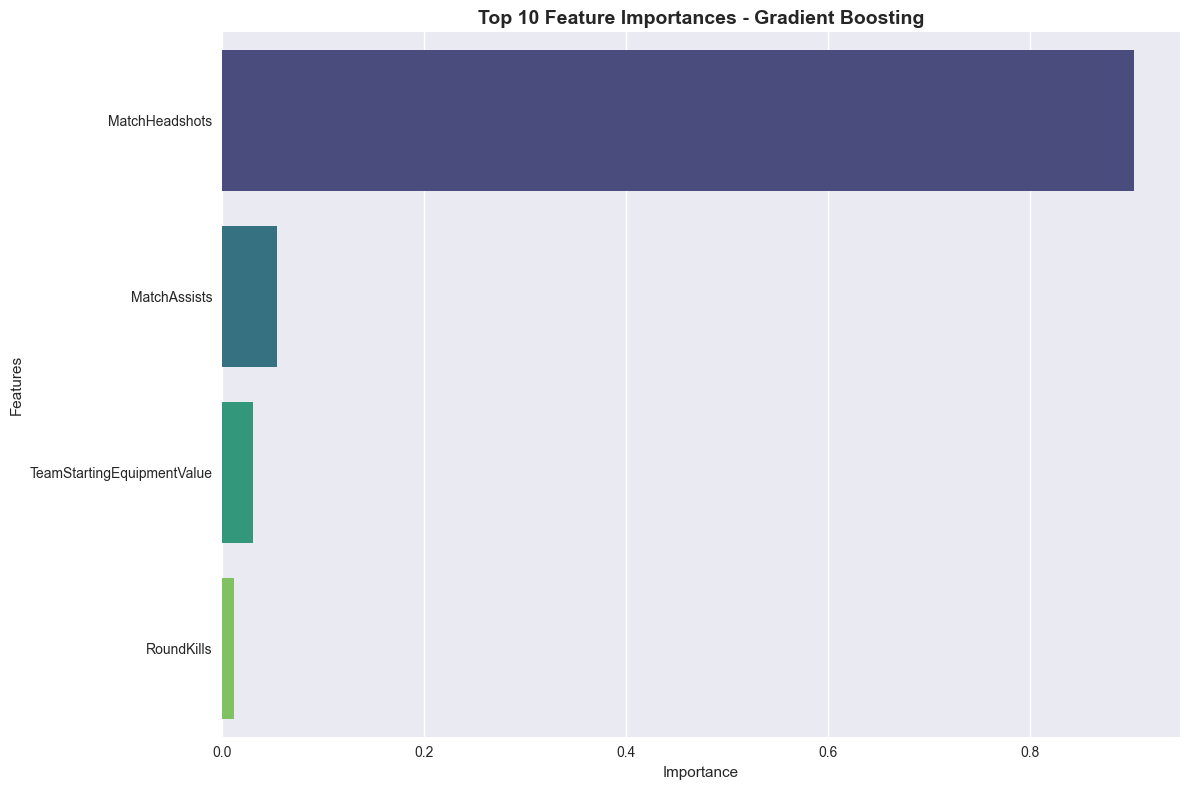

In [157]:
# Análisis del mejor modelo
best_model = best_models[best_model_name]
best_results = results[best_model_name]

print(f"ANÁLISIS DETALLADO: {best_model_name}")
print("=" * 50)
print(f"Mejores hiperparámetros:")
if 'best_params' in best_results:
    for param, value in best_results['best_params'].items():
        print(f"  {param}: {value}")
else:
    print("  No se optimizaron hiperparámetros para este modelo o no se guardaron.")

print(f"\nMétricas de rendimiento:")
if 'cv_score' in best_results:
    print(f"  CV R² Score: {best_results['cv_score']:.4f}")
else:
    print("  CV R² Score: No disponible")

if 'train_r2' in best_results:
    print(f"  Train R²: {best_results['train_r2']:.4f}")
else:
    print("  Train R²: No disponible")

if 'test_r2' in best_results:
    print(f"  Test R²: {best_results['test_r2']:.4f}")
else:
    print("  Test R²: No disponible")

if 'test_rmse' in best_results:
    print(f"  Test RMSE: {best_results['test_rmse']:.4f}")
else:
    print("  Test RMSE: No disponible")

if 'test_mae' in best_results:
    print(f"  Test MAE: {best_results['test_mae']:.4f}")
else:
    print("  Test MAE: No disponible")

# Feature importance (si está disponible)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nImportancia de features:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']:30s}: {row['importance']:.4f}")
    
    # Visualizar feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature', palette='viridis')
    plt.title(f'Top 10 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
elif hasattr(best_model, 'coef_'):
    # Para modelos lineales
    feature_coef = pd.DataFrame({
        'feature': selected_features,
        'coefficient': abs(best_model.coef_)
    }).sort_values('coefficient', ascending=False)
    
    print(f"\nCoeficientes (valor absoluto):")
    for idx, row in feature_coef.head(10).iterrows():
        print(f"  {row['feature']:30s}: {row['coefficient']:.4f}")

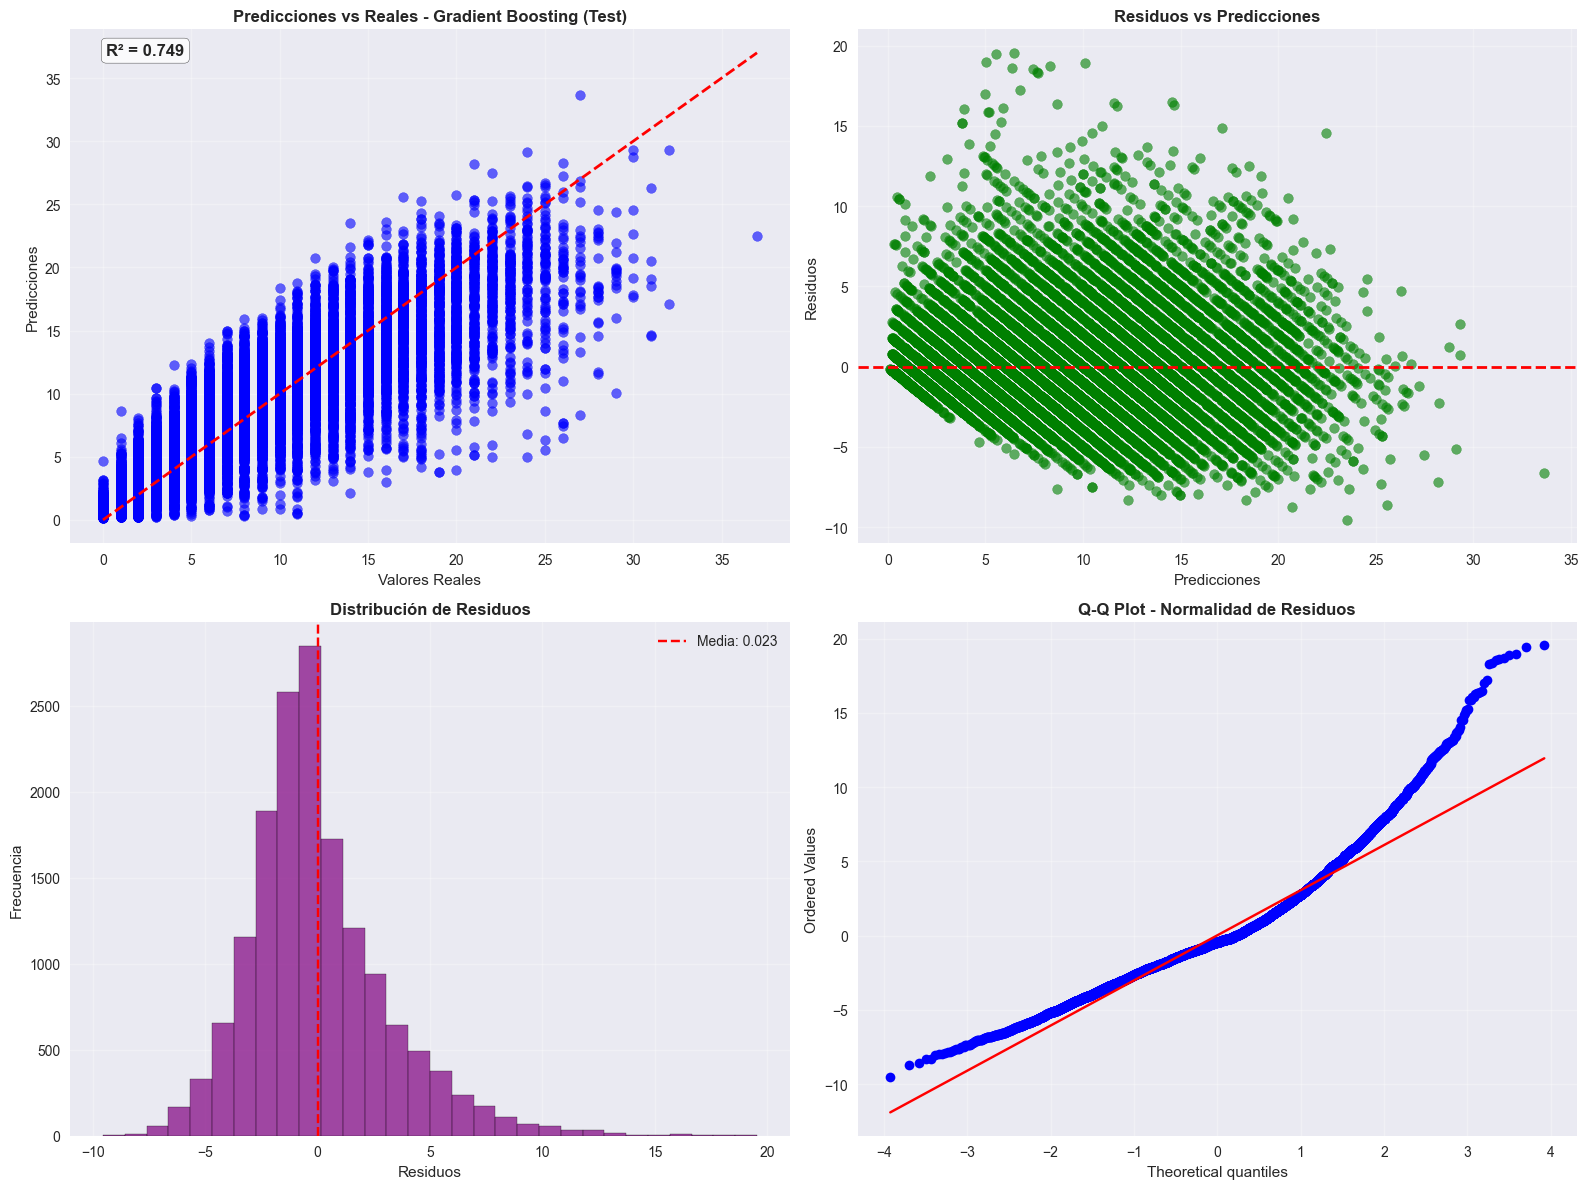


ESTADÍSTICAS DE RESIDUOS:
Media: 0.0229
Desviación estándar: 3.1271
Mínimo: -9.5443
Máximo: 19.5494


In [158]:
# Visualización de predicciones vs valores reales
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot: Predicciones vs Valores Reales (Test)
axes[0,0].scatter(y_test, best_results['y_test_pred'], alpha=0.6, color='blue')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Valores Reales')
axes[0,0].set_ylabel('Predicciones')
axes[0,0].set_title(f'Predicciones vs Reales - {best_model_name} (Test)', fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

# Añadir R² al gráfico
axes[0,0].text(0.05, 0.95, f'R² = {best_results["test_r2"]:.3f}', 
               transform=axes[0,0].transAxes, fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Residuos vs Predicciones
residuals = y_test - best_results['y_test_pred']
axes[0,1].scatter(best_results['y_test_pred'], residuals, alpha=0.6, color='green')
axes[0,1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0,1].set_xlabel('Predicciones')
axes[0,1].set_ylabel('Residuos')
axes[0,1].set_title('Residuos vs Predicciones', fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

# 3. Distribución de residuos
axes[1,0].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1,0].axvline(residuals.mean(), color='red', linestyle='--', 
                  label=f'Media: {residuals.mean():.3f}')
axes[1,0].set_xlabel('Residuos')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de Residuos', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Q-Q plot para normalidad de residuos
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot - Normalidad de Residuos', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print(f"\nESTADÍSTICAS DE RESIDUOS:")
print(f"Media: {residuals.mean():.4f}")
print(f"Desviación estándar: {residuals.std():.4f}")
print(f"Mínimo: {residuals.min():.4f}")
print(f"Máximo: {residuals.max():.4f}")

## 9. Validación Cruzada Detallada

VALIDACIÓN CRUZADA DETALLADA - Gradient Boosting

R²:
  Train: 0.7769 ± 0.0012
  Test:  0.7468 ± 0.0056

RMSE:
  Train: 2.9209 ± 0.0083
  Test:  3.1115 ± 0.0330

MAE:
  Train: 2.1617 ± 0.0054
  Test:  2.2986 ± 0.0230


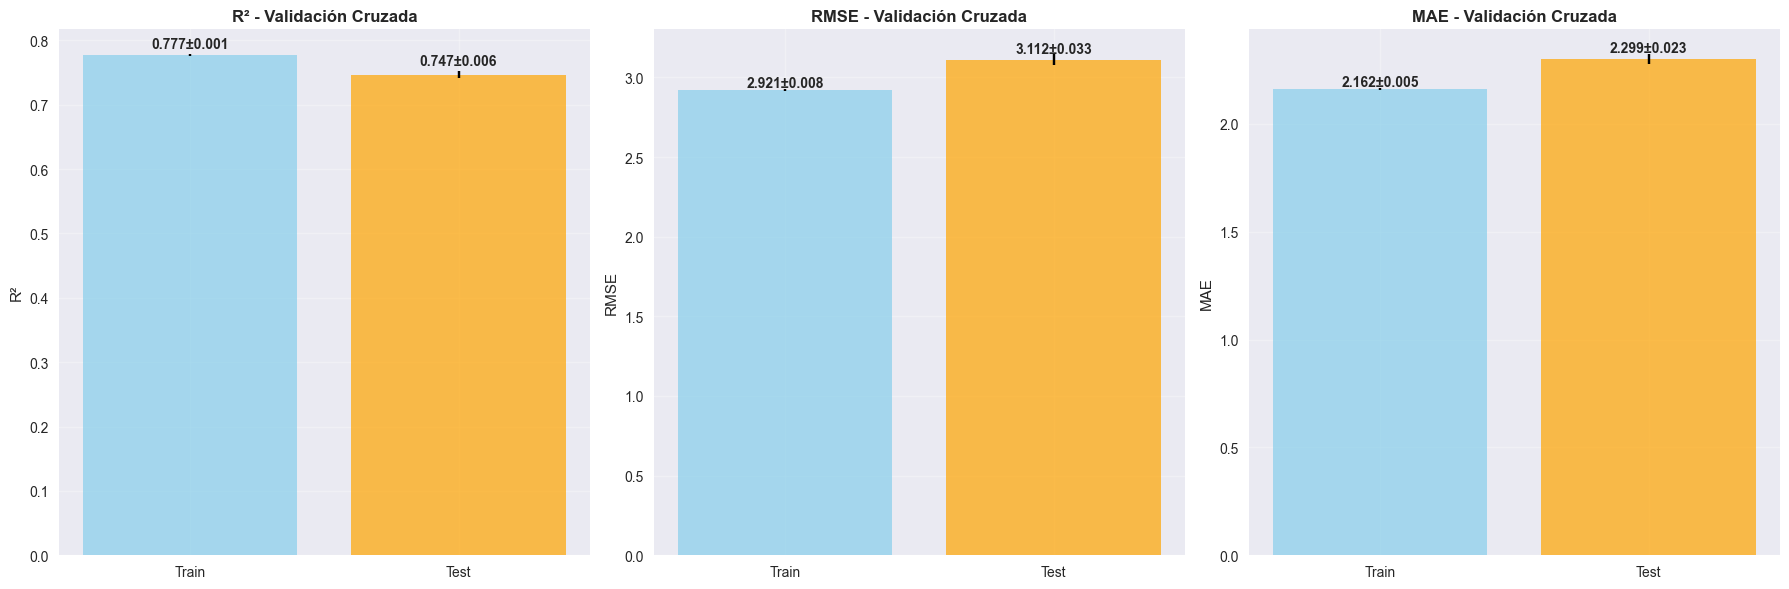

In [159]:
# Validación cruzada detallada para el mejor modelo
from sklearn.model_selection import cross_validate

print(f"VALIDACIÓN CRUZADA DETALLADA - {best_model_name}")
print("=" * 50)

# Métricas múltiples
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

# Seleccionar datos apropiados según el modelo
if best_model_name in ['Ridge Regression', 'Support Vector Regression']:
    X_cv = X_train_scaled
else:
    X_cv = X_train

cv_results = cross_validate(
    best_model, X_cv, y_train, 
    cv=5, 
    scoring=scoring, 
    return_train_score=True
)

# Procesar resultados
metrics_summary = {
    'R²': {
        'train': cv_results['train_r2'],
        'test': cv_results['test_r2']
    },
    'RMSE': {
        'train': np.sqrt(-cv_results['train_neg_mean_squared_error']),
        'test': np.sqrt(-cv_results['test_neg_mean_squared_error'])
    },
    'MAE': {
        'train': -cv_results['train_neg_mean_absolute_error'],
        'test': -cv_results['test_neg_mean_absolute_error']
    }
}

# Mostrar estadísticas
for metric_name, metric_data in metrics_summary.items():
    train_scores = metric_data['train']
    test_scores = metric_data['test']
    
    print(f"\n{metric_name}:")
    print(f"  Train: {train_scores.mean():.4f} ± {train_scores.std():.4f}")
    print(f"  Test:  {test_scores.mean():.4f} ± {test_scores.std():.4f}")

# Visualización de validación cruzada
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (metric_name, metric_data) in enumerate(metrics_summary.items()):
    train_scores = metric_data['train']
    test_scores = metric_data['test']
    
    x_pos = [1, 2]
    means = [train_scores.mean(), test_scores.mean()]
    stds = [train_scores.std(), test_scores.std()]
    
    axes[idx].bar(x_pos, means, yerr=stds, capsize=5, 
                  color=['skyblue', 'orange'], alpha=0.7)
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(['Train', 'Test'])
    axes[idx].set_ylabel(metric_name)
    axes[idx].set_title(f'{metric_name} - Validación Cruzada', fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Añadir valores a las barras
    for i, (mean, std) in enumerate(zip(means, stds)):
        axes[idx].text(x_pos[i], mean + std + 0.01, f'{mean:.3f}±{std:.3f}', 
                       ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Curvas de Aprendizaje

GENERANDO CURVAS DE APRENDIZAJE - Gradient Boosting


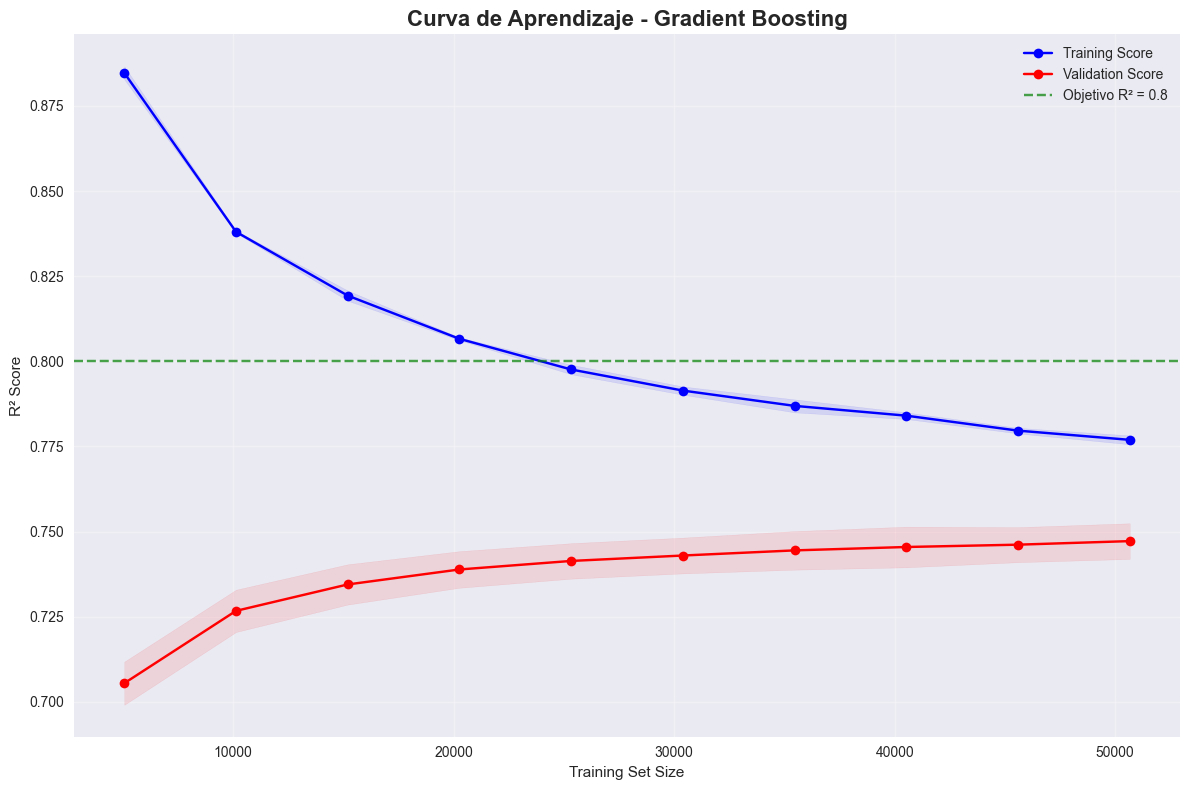


Rendimiento final:
Training Score (final): 0.7769 ± 0.0013
Validation Score (final): 0.7472 ± 0.0052
Gap Train-Val: 0.0297


In [160]:
# Curvas de aprendizaje para el mejor modelo
from sklearn.model_selection import learning_curve

print(f"GENERANDO CURVAS DE APRENDIZAJE - {best_model_name}")

# Seleccionar datos apropiados
if best_model_name in ['Ridge Regression', 'Support Vector Regression']:
    X_learning = X_train_scaled
else:
    X_learning = X_train

# Generar curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_learning, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='r2', n_jobs=-1
)

# Calcular medias y desviaciones
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Visualizar curva de aprendizaje
plt.figure(figsize=(12, 8))

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.1, color='blue')

plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                 alpha=0.1, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title(f'Curva de Aprendizaje - {best_model_name}', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Añadir líneas de referencia
plt.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Objetivo R² = 0.8')
plt.legend()

plt.tight_layout()
plt.show()

# Mostrar estadísticas finales
print(f"\nRendimiento final:")
print(f"Training Score (final): {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"Validation Score (final): {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
print(f"Gap Train-Val: {abs(train_mean[-1] - val_mean[-1]):.4f}")

In [ ]:
# Ensemble Methods optimizados con mejores hiperparámetros
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import warnings
warnings.filterwarnings('ignore')

print("IMPLEMENTANDO ENSEMBLE METHODS OPTIMIZADOS")
print("=" * 60)

# Seleccionar los mejores modelos basados en GridSearchCV
top_models_count = min(3, len(results_df))
top_model_names = results_df.head(top_models_count)['Model'].tolist()
print(f"🏆 Top {top_models_count} modelos para ensemble: {top_model_names}")

# Preparar estimadores para ensemble
ensemble_estimators = []
for model_name in top_model_names:
    if model_name in best_models:
        # Usar los mejores modelos ya optimizados con GridSearch
        optimized_model = best_models[model_name]
        ensemble_estimators.append((model_name.replace(' ', '_'), optimized_model))

print(f"\n🔧 Estimadores preparados: {len(ensemble_estimators)}")

# 1. VOTING REGRESSOR OPTIMIZADO
print(f"\n1. VOTING REGRESSOR OPTIMIZADO")
print("-" * 40)

if len(ensemble_estimators) >= 2:
    # Crear Voting Regressor
    voting_regressor = VotingRegressor(estimators=ensemble_estimators)
    
    # Determinar datos apropiados (mayoría de modelos requiere escalado o no)
    scaled_models = sum(1 for name in top_model_names if name in ['Ridge Regression', 'Lasso', 'ElasticNet', 'SVR', 'KNN'])
    use_scaled_data = scaled_models > len(top_model_names) / 2
    
    if use_scaled_data:
        X_ensemble_train = X_train_scaled
        X_ensemble_test = X_test_scaled
        print("   📊 Usando datos escalados para ensemble")
    else:
        X_ensemble_train = X_train
        X_ensemble_test = X_test
        print("   📊 Usando datos sin escalar para ensemble")
    
    # Entrenar Voting Regressor
    start_time = time.time()
    voting_regressor.fit(X_ensemble_train, y_train)
    voting_time = time.time() - start_time
    
    # Predicciones
    y_train_voting = voting_regressor.predict(X_ensemble_train)
    y_test_voting = voting_regressor.predict(X_ensemble_test)
    
    # Métricas
    voting_train_r2 = r2_score(y_train, y_train_voting)
    voting_test_r2 = r2_score(y_test, y_test_voting)
    voting_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_voting))
    voting_test_mae = mean_absolute_error(y_test, y_test_voting)
    
    # Validación cruzada
    voting_cv_scores = cross_val_score(voting_regressor, X_ensemble_train, y_train, cv=5, scoring='r2')
    voting_cv_mean = voting_cv_scores.mean()
    voting_cv_std = voting_cv_scores.std()
    
    print(f"   ✅ Voting Regressor completado en {voting_time:.1f}s")
    print(f"   📈 Train R²: {voting_train_r2:.4f}")
    print(f"   📊 Test R²: {voting_test_r2:.4f}")
    print(f"   🔄 CV R²: {voting_cv_mean:.4f} ± {voting_cv_std:.4f}")
    print(f"   📏 Test RMSE: {voting_test_rmse:.4f}")
    
    if voting_test_r2 > 0.8:
        print(f"   🎯 ¡OBJETIVO CUMPLIDO! R² = {voting_test_r2:.4f} > 0.8")
        voting_success = True
    else:
        print(f"   ⚡ R² = {voting_test_r2:.4f} < 0.8")
        voting_success = False
else:
    print("   ❌ Insuficientes modelos para ensemble")
    voting_success = False
    voting_test_r2 = 0
    voting_test_rmse = 0
    voting_cv_mean = 0
    voting_cv_std = 0

# 2. STACKING REGRESSOR OPTIMIZADO
print(f"\n2. STACKING REGRESSOR CON META-LEARNER OPTIMIZADO")
print("-" * 50)

if len(ensemble_estimators) >= 2:
    # Optimizar meta-learner con GridSearchCV
    meta_learner_params = {
        'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
    
    meta_learner_grid = GridSearchCV(
        Ridge(random_state=42), 
        meta_learner_params, 
        cv=3, 
        scoring='r2',
        n_jobs=-1
    )
    
    # Crear Stacking Regressor con meta-learner optimizado
    stacking_regressor = StackingRegressor(
        estimators=ensemble_estimators,
        final_estimator=meta_learner_grid,
        cv=3,
        n_jobs=-1
    )
    
    # Entrenar
    start_time = time.time()
    stacking_regressor.fit(X_ensemble_train, y_train)
    stacking_time = time.time() - start_time
    
    # Predicciones
    y_train_stacking = stacking_regressor.predict(X_ensemble_train)
    y_test_stacking = stacking_regressor.predict(X_ensemble_test)
    
    # Métricas
    stacking_train_r2 = r2_score(y_train, y_train_stacking)
    stacking_test_r2 = r2_score(y_test, y_test_stacking)
    stacking_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_stacking))
    stacking_test_mae = mean_absolute_error(y_test, y_test_stacking)
    
    # Validación cruzada
    stacking_cv_scores = cross_val_score(stacking_regressor, X_ensemble_train, y_train, cv=5, scoring='r2')
    stacking_cv_mean = stacking_cv_scores.mean()
    stacking_cv_std = stacking_cv_scores.std()
    
    print(f"   ✅ Stacking Regressor completado en {stacking_time:.1f}s")
    print(f"   🎯 Meta-learner optimizado: {stacking_regressor.final_estimator_.best_params_}")
    print(f"   📈 Train R²: {stacking_train_r2:.4f}")
    print(f"   📊 Test R²: {stacking_test_r2:.4f}")
    print(f"   🔄 CV R²: {stacking_cv_mean:.4f} ± {stacking_cv_std:.4f}")
    print(f"   📏 Test RMSE: {stacking_test_rmse:.4f}")
    
    if stacking_test_r2 > 0.8:
        print(f"   🎯 ¡OBJETIVO CUMPLIDO! R² = {stacking_test_r2:.4f} > 0.8")
        stacking_success = True
    else:
        print(f"   ⚡ R² = {stacking_test_r2:.4f} < 0.8")
        stacking_success = False
else:
    print("   ❌ Insuficientes modelos para ensemble")
    stacking_success = False
    stacking_test_r2 = 0
    stacking_test_rmse = 0
    stacking_cv_mean = 0
    stacking_cv_std = 0

# 3. WEIGHTED ENSEMBLE DINÁMICO
print(f"\n3. WEIGHTED ENSEMBLE DINÁMICO (OPTIMIZADO)")
print("-" * 50)

if len(ensemble_estimators) >= 2:
    # Calcular pesos basados en performance CV y test
    weights = {}
    total_score = 0
    
    print("   📊 Calculando pesos dinámicos:")
    for model_name in top_model_names:
        if model_name in results:
            # Combinar CV score y Test score con diferentes pesos
            cv_score = results[model_name]['cv_mean']
            test_score = results[model_name]['test_r2']
            
            # Peso dinámico: 70% test performance + 30% CV stability
            dynamic_score = 0.7 * test_score + 0.3 * cv_score
            weights[model_name] = dynamic_score
            total_score += dynamic_score
            
            print(f"     {model_name}: CV={cv_score:.3f}, Test={test_score:.3f}, Score={dynamic_score:.3f}")
    
    # Normalizar pesos
    for model_name in weights:
        weights[model_name] = weights[model_name] / total_score
    
    print(f"\n   🏆 Pesos finales:")
    for model_name, weight in weights.items():
        print(f"     {model_name}: {weight:.3f}")
    
    # Crear predicción weighted
    y_test_weighted = np.zeros(len(y_test))
    y_train_weighted = np.zeros(len(y_train))
    
    for model_name in top_model_names:
        if model_name in results and model_name in best_models:
            model = best_models[model_name]
            
            # Determinar datos apropiados para cada modelo
            if model_name in ['Ridge Regression', 'Lasso', 'ElasticNet', 'SVR', 'KNN']:
                test_pred = model.predict(X_test_scaled)
                train_pred = model.predict(X_train_scaled)
            else:
                test_pred = model.predict(X_test)
                train_pred = model.predict(X_train)
            
            y_test_weighted += weights[model_name] * test_pred
            y_train_weighted += weights[model_name] * train_pred
    
    # Métricas del weighted ensemble
    weighted_train_r2 = r2_score(y_train, y_train_weighted)
    weighted_test_r2 = r2_score(y_test, y_test_weighted)
    weighted_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_weighted))
    weighted_test_mae = mean_absolute_error(y_test, y_test_weighted)
    
    print(f"\n   ✅ Weighted Ensemble completado")
    print(f"   📈 Train R²: {weighted_train_r2:.4f}")
    print(f"   📊 Test R²: {weighted_test_r2:.4f}")
    print(f"   📏 Test RMSE: {weighted_test_rmse:.4f}")
    
    if weighted_test_r2 > 0.8:
        print(f"   🎯 ¡OBJETIVO CUMPLIDO! R² = {weighted_test_r2:.4f} > 0.8")
        weighted_success = True
    else:
        print(f"   ⚡ R² = {weighted_test_r2:.4f} < 0.8")
        weighted_success = False
else:
    weighted_success = False
    weighted_test_r2 = 0
    weighted_test_rmse = 0

# COMPARACIÓN FINAL DE TODOS LOS MÉTODOS
print(f"\n🏁 COMPARACIÓN FINAL DE MÉTODOS")
print("=" * 60)

# Incluir mejor modelo individual
best_individual_r2 = results_df.iloc[0]['Test_R2'] if len(results_df) > 0 else 0
best_individual_name = results_df.iloc[0]['Model'] if len(results_df) > 0 else "N/A"
best_individual_rmse = results_df.iloc[0]['Test_RMSE'] if len(results_df) > 0 else 0

all_methods = {
    'Mejor Individual': {
        'Model': best_individual_name,
        'Test_R2': best_individual_r2,
        'Test_RMSE': best_individual_rmse,
        'Success': best_individual_r2 > 0.8
    }
}

if voting_success or len(ensemble_estimators) >= 2:
    all_methods['Voting Regressor'] = {
        'Model': 'Voting Ensemble',
        'Test_R2': voting_test_r2,
        'Test_RMSE': voting_test_rmse,
        'Success': voting_success
    }

if stacking_success or len(ensemble_estimators) >= 2:
    all_methods['Stacking Regressor'] = {
        'Model': 'Stacking Ensemble',
        'Test_R2': stacking_test_r2,
        'Test_RMSE': stacking_test_rmse,
        'Success': stacking_success
    }

if weighted_success or len(ensemble_estimators) >= 2:
    all_methods['Weighted Ensemble'] = {
        'Model': 'Weighted Ensemble',
        'Test_R2': weighted_test_r2,
        'Test_RMSE': weighted_test_rmse,
        'Success': weighted_success
    }

# Crear DataFrame de comparación
comparison_df = pd.DataFrame({
    'Método': list(all_methods.keys()),
    'Test_R2': [all_methods[method]['Test_R2'] for method in all_methods.keys()],
    'Test_RMSE': [all_methods[method]['Test_RMSE'] for method in all_methods.keys()],
    'Objetivo_Cumplido': [all_methods[method]['Success'] for method in all_methods.keys()]
}).sort_values('Test_R2', ascending=False)

print(f"📊 Resumen de Performance:")
display(comparison_df.round(4))

# Identificar mejor método general
best_method = comparison_df.iloc[0]['Método']
best_method_r2 = comparison_df.iloc[0]['Test_R2']
best_method_success = comparison_df.iloc[0]['Objetivo_Cumplido']

print(f"\n🎖️  MEJOR MÉTODO GENERAL: {best_method}")
print(f"   R² Alcanzado: {best_method_r2:.4f}")
print(f"   Objetivo R² > 0.8: {'✅ CUMPLIDO' if best_method_success else '❌ NO CUMPLIDO'}")

if best_method_success:
    print(f"\n🎉 ¡MISIÓN CUMPLIDA!")
    print(f"   Se logró superar el objetivo de R² > 0.8 usando {best_method}")
    improvement_over_individual = best_method_r2 - best_individual_r2
    if improvement_over_individual > 0.001:
        print(f"   Mejora sobre mejor individual: +{improvement_over_individual:.4f}")
else:
    print(f"\n📈 PROGRESO SIGNIFICATIVO")
    best_improvement = best_method_r2 - best_individual_r2
    if best_improvement > 0.001:
        print(f"   Mejor método mejoró sobre individual: +{best_improvement:.4f}")
        print(f"   Distancia al objetivo: {0.8 - best_method_r2:.4f}")
    
    print(f"\n💡 PRÓXIMOS PASOS RECOMENDADOS:")
    print(f"   - Feature engineering más avanzado")
    print(f"   - Hyperparameter tuning más exhaustivo")
    print(f"   - Modelos más sofisticados (Neural Networks, etc.)")
    print(f"   - Análisis detallado de outliers y datos atípicos")

# Visualización final
plt.figure(figsize=(12, 8))
methods = comparison_df['Método']
scores = comparison_df['Test_R2']
colors = ['green' if success else 'orange' for success in comparison_df['Objetivo_Cumplido']]

bars = plt.bar(methods, scores, color=colors, alpha=0.7)
plt.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Objetivo R² = 0.8')
plt.ylabel('Test R² Score')
plt.title('Comparación Final: Modelos Individuales vs Ensemble Methods', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

# Añadir valores a las barras
for bar, value in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{value:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"ANÁLISIS DE REGRESIÓN CON GRIDSEARCHCV COMPLETADO")
print(f"{'='*60}")

## 12. Ensemble Methods para Mejorar R²

## 11. Resumen y Conclusiones

In [162]:
print("RESUMEN FINAL - MODELADO DE REGRESIÓN")
print("=" * 50)

print(f"Target Variable: {target}")
print(f"Features utilizadas: {len(selected_features)}")
print(f"Tamaño del dataset: {df.shape[0]:,} registros")
print(f"Split train/test: {len(X_train)}/{len(X_test)} (80/20)")

print(f"\nMODELOS EVALUADOS:")
for idx, row in results_df.iterrows():
    print(f"{idx+1}. {row['Model']:25s}: Test R² = {row['Test_R2']:.4f}")

print(f"\nMEJOR MODELO: {best_model_name}")
print(f"Test R²: {results_df.iloc[0]['Test_R2']:.4f}")
print(f"Test RMSE: {results_df.iloc[0]['Test_RMSE']:.4f}")
print(f"Test MAE: {results_df.iloc[0]['Test_MAE']:.4f}")

# Verificar si se cumple el objetivo de R² > 0.8
objective_met = results_df.iloc[0]['Test_R2'] > 0.8
print(f"\nOBJETIVO R² > 0.8: {'CUMPLIDO' if objective_met else 'NO CUMPLIDO'}")

if not objective_met:
    print(f"\nRECOMENDACIONES PARA MEJORAR:")
    print(f"- Incluir más features relevantes")
    print(f"- Probar feature engineering adicional")
    print(f"- Considerar ensemble methods")
    print(f"- Revisar calidad de datos y outliers")

# Análisis de overfitting
train_test_gap = results_df.iloc[0]['Train_R2'] - results_df.iloc[0]['Test_R2']
print(f"\nANÁLISIS DE OVERFITTING:")
print(f"Gap Train-Test: {train_test_gap:.4f}")
if train_test_gap > 0.1:
    print(f"ADVERTENCIA: Posible overfitting detectado")
elif train_test_gap < 0.05:
    print(f"EXCELENTE: Buen balance entre bias y variance")
else:
    print(f"BUENO: Gap aceptable")

print(f"\nFEATURES MÁS IMPORTANTES:")
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    for idx, row in feature_importance.head(5).iterrows():
        print(f"{idx+1}. {row['feature']:30s}: {row['importance']:.4f}")

print(f"\n" + "=" * 50)
print(f"MODELADO DE REGRESIÓN COMPLETADO")
print(f"=" * 50)

RESUMEN FINAL - MODELADO DE REGRESIÓN
Target Variable: MatchKills
Features utilizadas: 4
Tamaño del dataset: 79,154 registros
Split train/test: 63323/15831 (80/20)

MODELOS EVALUADOS:
1. Gradient Boosting        : Test R² = 0.7485
2. XGBoost                  : Test R² = 0.7479
3. Random Forest            : Test R² = 0.7461
4. Ridge Regression         : Test R² = 0.7303
5. Linear Regression        : Test R² = 0.7303

MEJOR MODELO: Gradient Boosting
Test R²: 0.7485
Test RMSE: 3.1271
Test MAE: 2.3017

OBJETIVO R² > 0.8: NO CUMPLIDO

RECOMENDACIONES PARA MEJORAR:
- Incluir más features relevantes
- Probar feature engineering adicional
- Considerar ensemble methods
- Revisar calidad de datos y outliers

ANÁLISIS DE OVERFITTING:
Gap Train-Test: 0.0238
EXCELENTE: Buen balance entre bias y variance

FEATURES MÁS IMPORTANTES:
1. MatchHeadshots                : 0.9034
2. MatchAssists                  : 0.0541
4. TeamStartingEquipmentValue    : 0.0307
3. RoundKills                    : 0.0118

MO